## Imports

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
# TensorFlow Baby
import tensorflow as tf

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(255,255,255,255)', plot_bgcolor='rgba(0,0,0,0.8)')

fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)

pio.templates['xgboost'] = templated_fig.layout.template
pio.templates.default = 'xgboost'


## SBG LOADER

In [3]:
def sbg_dloader(data_dir=str, start_date=int) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(data_dir))

    df.rename(columns={'Closing (c)': 'Close'}, inplace=True)
    df.rename(columns={'High (c)': 'High'}, inplace=True)
    df.rename(columns={'Low (c)': 'Low'}, inplace=True)

    # Date convert
    df['Date'] = pd.to_datetime(df['Date'])

    # Select date range
    df = df[(df['Date'].dt.year >= start_date)].copy()

    df.index = range(len(df))

    df = df.sort_values(by='Date')

    return pd.DataFrame(df)


## Decomposer

In [4]:
def sbg_decomposer(df=pd.DataFrame, feature=str, period=int):
    decompose_df = df[['Date', feature]].copy()
    decompose_df = decompose_df.set_index('Date')

    decompose = seasonal_decompose(decompose_df, period=period)

    return decompose


## SBG Technical Indicators

In [5]:
def moving_averages(df=pd.DataFrame, feature=str):
    df['EMA_9'] = df[feature].ewm(9).mean().shift()
    df['SMA_5'] = df[feature].rolling(5).mean().shift()
    df['SMA_10'] = df[feature].rolling(10).mean().shift()
    df['SMA_15'] = df[feature].rolling(15).mean().shift()
    df['SMA_30'] = df[feature].rolling(30).mean().shift()

    return df


## Relative Strength Index (RSI)

In [6]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi


## MACD

### Plotter

In [7]:
def plot_macd(df, ema_12, ema_26):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=ema_12, name='EMA 12'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=ema_26, name='EMA 26'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
    fig.show()


### Calculator

In [8]:
def macd(df=pd.DataFrame):
    ema_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    ema_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())

    df['MACD'] = pd.Series(ema_12 - ema_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

    # plot_macd(df, ema_12, ema_26)

    return ema_12, ema_26


## SBG Splitter

In [9]:
def sbg_splitter(df=pd.DataFrame, test_size=float, valid_size=float):
    test_split_idx  = int(df.shape[0] * (1-test_size))
    valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

    train_df = df.loc[:valid_split_idx].copy()
    valid_df = df.loc[valid_split_idx+1:test_split_idx].copy()
    test_df  = df.loc[test_split_idx+1:].copy()



    return train_df, valid_df, test_df


## SBG Preproceser

In [10]:
def sbg_dropper(train_df=pd.DataFrame, valid_df=pd.DataFrame, test_df=pd.DataFrame, columns=list):
    train_df = train_df.drop(columns, axis=1)
    valid_df = valid_df.drop(columns, axis=1)
    test_df  = test_df.drop(columns, axis=1)

    return train_df, valid_df, test_df


## SBG Fitter

### Model Loader

In [11]:
def model_loader(model_dir):
    return tf.keras.models.load_model(os.path.join(model_dir))


### Model Train

In [24]:
def model_train1(train_df=pd.DataFrame, valid_df=pd.DataFrame, target=str, epochs=50, batch=34):
    y_train = train_df[target].copy()
    X_train = train_df.drop([target], axis=1)

    y_valid = valid_df[target].copy()
    X_valid = valid_df.drop([target], axis=1)

    nn_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(34, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    nn_model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())

    # Train the model
    nn_model.fit(
        X_train, 
        y_train,
        epochs=epochs, 
        batch_size=batch,
        validation_data=(X_valid, y_valid)
    )

    return nn_model

def model_train(train_df=pd.DataFrame, valid_df=pd.DataFrame, target=str, epochs=50, batch=34):
    y_train = train_df[target].copy()
    X_train = train_df.drop([target], axis=1)

    y_valid = valid_df[target].copy()
    X_valid = valid_df.drop([target], axis=1)

    scaler = MinMaxScaler(feature_range=(0,1))
    X_train_scaled = scaler.fit_transform(X_train)

    nn_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1],1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(100, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Dropout(0.2),        
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])

    nn_model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())

    # Train the model
    nn_model.fit(
        X_train, 
        y_train,
        epochs=epochs, 
        batch_size=batch,
        validation_data=(X_valid, y_valid)
    )

    return nn_model


### Model Predict

In [13]:
def model_predict(test_set=pd.DataFrame, test_df=pd.DataFrame, target=str, trained_model=any):
    y_test  = test_df[target].copy()
    X_test  = test_df.drop([target], axis=1)

    y_pred = trained_model.predict(X_test)

    # # Reshape y_pred to be 1D if it has an extra dimension
    # y_pred_plot = y_pred.reshape(-1)

    # plt.figure(figsize=(12, 6))
    # plt.plot(test_set.Date, y_test, label='Actual')
    # plt.plot(test_set.Date, y_pred_plot, label='Predicted')
    # plt.xlabel('Date')
    # plt.ylabel('Close Price')
    # plt.title('Actual vs Predicted')
    # plt.legend()
    # plt.show()

    return y_pred


## >> Test Space <<

#### Data Loader

In [14]:
# Load in dataset
data_dir = r'../data/mtn.csv'
df = sbg_dloader(data_dir, 2020)
df1 = df.copy()


#### Decomposer

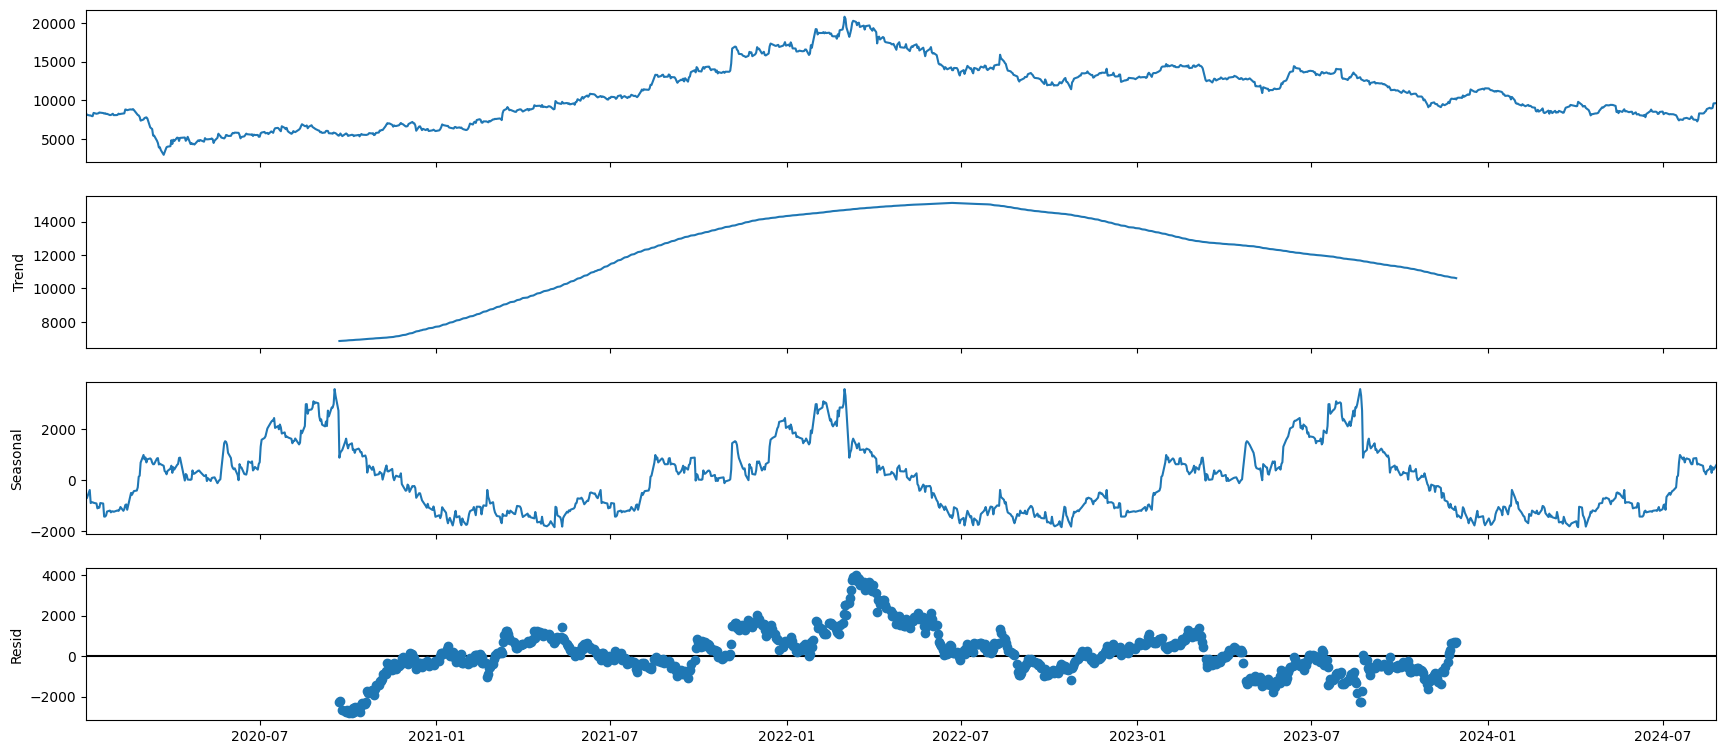

In [15]:
target = 'Close'
decompose = sbg_decomposer(df, target, 365)

fig = decompose.plot()
fig.set_size_inches(20, 8)


#### Technical Indicators (MA)

In [16]:
df = moving_averages(df, target)


#### Technical Indicators (RSI)

In [17]:
df['RSI'] = relative_strength_idx(df)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()


#### Technical Indicators (MACD)

In [18]:
ema_12, ema_26 = macd(df)


#### Boilerplate

In [19]:
df['Close'] = df['Close'].shift(-1)
df

,Date,Close,High,Low,Volume,# Deals,Value (R),Move (%),DY,EY,PE,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
1162,2020-01-02,8123.0,8408,8221,3310523,3547,"276,246,222",1.41%,4.9731,3.7895,26.3880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1161,2020-01-03,8039.0,8347,8051,3407177,5132,"277,911,123",-2.89%,5.1212,3.9024,25.6246,8365.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1160,2020-01-06,8040.0,8188,7958,3130461,3894,"251,580,640",-1.03%,5.1747,3.9432,25.3596,8237.631579,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159,2020-01-07,7961.0,8141,7910,2415969,4021,"194,195,786",0.01%,5.1741,3.9427,25.3627,8164.335793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1158,2020-01-08,7946.0,7995,7900,2350768,3162,"186,977,281",-0.98%,5.2254,3.9819,25.1135,8128.181157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2024-08-20,8948.0,9116,8835,5026358,13038,"450,883,860",-0.86%,2.9497,-2.2458,-44.5273,8175.445905,8665.8,8217.6,8039.466667,7939.766667,73.145780,234.304066,70.672427
3,2024-08-21,9011.0,9079,8801,3874440,11034,"345,373,426",-0.02%,2.9503,-2.2463,-44.5174,8252.901315,8789.2,8366.5,8131.333333,7965.433333,70.649144,259.135405,108.365022
2,2024-08-22,9593.0,9214,8961,4317063,8147,"391,511,145",0.70%,2.9297,-2.2306,-44.8308,8322.411183,8879.4,8534.3,8215.666667,7989.900000,76.573572,280.662689,142.824556
1,2024-08-23,9634.0,9593,8999,7656352,14790,"721,621,357",6.46%,2.7520,-2.0952,-47.7263,8391.270065,8960.4,8683.4,8289.000000,8016.966667,87.676694,340.757710,182.411187


In [20]:
df = df.iloc[33:]
df = df[:-1]

df.index = range(len(df))


### Splitter

In [21]:
train_set, valid_set, test_set = sbg_splitter(df, .15, .15)
test_set

,Date,Close,High,Low,Volume,# Deals,Value (R),Move (%),DY,EY,PE,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
960,2023-12-19,11067.0,11219,11026,3601160,8731,"399,556,973",0.00%,0.0000,0.0000,0.0000,10493.914422,10944.6,10694.7,10538.266667,10057.366667,69.633274,287.715894,184.888853
961,2023-12-20,11216.0,11233,11067,3758025,8258,"418,292,580",-0.39%,2.3854,10.7526,9.3000,10555.522980,11015.4,10772.3,10601.266667,10103.400000,72.519795,292.151418,206.341366
962,2023-12-21,11336.0,11216,10730,11148440,5426,"1,207,259,454",1.35%,2.3537,10.6098,9.4252,10606.670682,11088.4,10849.0,10656.933333,10153.966667,71.931494,304.183222,225.909737
963,2023-12-22,11500.0,11469,11030,1453829,3976,"164,430,933",1.07%,2.3288,10.4975,9.5260,10667.603614,11180.6,10908.4,10731.333333,10211.033333,72.935780,319.716023,244.670994
964,2023-12-27,11379.0,11800,11050,4714982,10739,"540,078,855",1.45%,2.2956,10.3478,9.6638,10734.443252,11167.8,10996.5,10800.800000,10271.933333,74.893254,341.324730,264.001741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,2024-08-19,8950.0,9083,8673,6419368,10333,"573,060,367",1.84%,2.9242,3.4891,28.6603,8080.717673,8518.2,8066.2,7952.666667,7916.633333,76.281588,198.998552,29.764517
1125,2024-08-20,8948.0,9116,8835,5026358,13038,"450,883,860",-0.86%,2.9497,-2.2458,-44.5273,8175.445905,8665.8,8217.6,8039.466667,7939.766667,73.145780,234.304066,70.672427
1126,2024-08-21,9011.0,9079,8801,3874440,11034,"345,373,426",-0.02%,2.9503,-2.2463,-44.5174,8252.901315,8789.2,8366.5,8131.333333,7965.433333,70.649144,259.135405,108.365022
1127,2024-08-22,9593.0,9214,8961,4317063,8147,"391,511,145",0.70%,2.9297,-2.2306,-44.8308,8322.411183,8879.4,8534.3,8215.666667,7989.900000,76.573572,280.662689,142.824556


### Dropper

In [22]:
drop_cols = ['Date', 'Volume', 'Low', 'High', '# Deals','Value (R)', 'Move (%)', 'DY', 'EY', 'PE']

train_df, valid_df, test_df = sbg_dropper(train_set, valid_set, test_set, drop_cols)


### Fitter

In [25]:
model = model_train(
    train_df=train_df,
    valid_df=valid_df,
    target=target,
    epochs=85
).save('test_model.keras')
df


d:\Prototypes\SBG\sbg-neural-network\kerasfin-forcaster\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 11122.1660 - val_loss: 11871.9580
Epoch 2/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11181.9902 - val_loss: 11846.5605
Epoch 3/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11187.5059 - val_loss: 11816.9297
Epoch 4/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10848.0898 - val_loss: 11781.2402
Epoch 5/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11158.7334 - val_loss: 11738.5439
Epoch 6/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10952.1738 - val_loss: 11689.0400
Epoch 7/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11118.9238 - val_loss: 11632.6406
Epoch 8/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 10845.2930 - val_loss: 11569.1318
Epoch 9/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11045.6982 - val_loss: 11498.3740
Epoch 10/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10506.5762 - val_loss: 11420.4111
Epoch 11/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10678.607

,Date,Close,High,Low,Volume,# Deals,Value (R),Move (%),DY,EY,PE,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-02-18,8800.0,8836,8673,3074011,5667,"269,885,959",-0.05%,4.7186,3.5957,27.8107,8420.507276,8689.6,8456.0,8350.466667,8293.200000,74.302939,131.754726,80.243308
1,2020-02-19,8860.0,8925,8737,4838732,7633,"426,901,527",-0.18%,4.7272,3.6022,27.7602,8461.187995,8790.6,8525.9,8398.200000,8319.066667,71.553785,140.153668,93.666706
2,2020-02-20,8739.0,8895,8720,2927310,6132,"258,917,850",0.68%,4.6952,3.5778,27.9495,8495.939069,8788.6,8578.7,8440.133333,8347.033333,84.405286,149.621782,105.909357
3,2020-02-21,8279.0,8849,8645,3549061,6851,"310,379,612",-1.37%,4.7602,3.6274,27.5678,8533.184236,8803.6,8644.4,8480.200000,8377.500000,76.102646,146.168840,114.555406
4,2020-02-24,8104.0,8666,8228,4886171,6695,"409,828,163",-5.26%,5.0247,3.8289,26.1167,8554.191751,8807.0,8694.6,8524.200000,8389.900000,54.827175,106.900777,112.935420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,2024-08-19,8950.0,9083,8673,6419368,10333,"573,060,367",1.84%,2.9242,3.4891,28.6603,8080.717673,8518.2,8066.2,7952.666667,7916.633333,76.281588,198.998552,29.764517
1125,2024-08-20,8948.0,9116,8835,5026358,13038,"450,883,860",-0.86%,2.9497,-2.2458,-44.5273,8175.445905,8665.8,8217.6,8039.466667,7939.766667,73.145780,234.304066,70.672427
1126,2024-08-21,9011.0,9079,8801,3874440,11034,"345,373,426",-0.02%,2.9503,-2.2463,-44.5174,8252.901315,8789.2,8366.5,8131.333333,7965.433333,70.649144,259.135405,108.365022
1127,2024-08-22,9593.0,9214,8961,4317063,8147,"391,511,145",0.70%,2.9297,-2.2306,-44.8308,8322.411183,8879.4,8534.3,8215.666667,7989.900000,76.573572,280.662689,142.824556


### Forecaster

In [26]:
loaded_model = model_loader('test_model.keras')


In [27]:
y_pred = model_predict(test_set, test_df, target, loaded_model)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


In [28]:
from datetime import datetime, timedelta
import pandas as pd

# train_set, valid_set, test_set = sbg_splitter(df, .15, .15)

drop_cols = ['Date']

# train_df, valid_df, test_df = sbg_dropper(train_set, valid_set, test_set, drop_cols)

loaded_model = model_loader('test_model.keras')

start_date = datetime(2023, 8, 8)
end_date = datetime(2023, 8, 13)

# Set the current_date to the start_date
current_date = start_date
forecasted_df = df.copy()

new_row = pd.DataFrame([{
    'Date': pd.to_datetime(current_date).strftime('%Y-%m-%d 00:00:00'),
    'Close': y_pred[0,0]
}])

forecasted_df = pd.concat([forecasted_df, new_row], ignore_index=True)

forecasted_values = pd.DataFrame()

# Loop through the dates from start_date to end_date
while current_date <= end_date:
    # Apply moving averages and other indicators to forecasted_df
    forecasted_df = moving_averages(forecasted_df, target)
    
    forecasted_df['RSI'] = relative_strength_idx(forecasted_df)
    
    ema_12, ema_26 = macd(forecasted_df)
    
    forecasted_df['Close'] = forecasted_df['Close'].shift(-1)
    
    forecasted_df = forecasted_df.iloc[33:]
    forecasted_df = forecasted_df[:-1]

    forecasted_df.index = range(len(forecasted_df))

    train_set, valid_set, test_set = sbg_splitter(forecasted_df, .15, .15)

    # Drop unnecessary columns after appending the new row
    drop_cols = ['Date', 'Volume', 'Low', 'High', '# Deals','Value (R)', 'Move (%)', 'DY', 'EY', 'PE']

    train_df, valid_df, test_df = sbg_dropper(train_set, valid_set, test_set, drop_cols)
    
    model = model_train(
        train_df=train_df,
        valid_df=valid_df,
        target=target,
        epochs=85
    )

    y_pred = model_predict(test_set, test_df, target, model)

    new_row = pd.DataFrame([{
        'Date': pd.to_datetime(current_date).strftime('%Y-%m-%d 00:00:00'),
        'Close': y_pred[0,0]
    }])

    forecasted_values = pd.concat([forecasted_values, new_row], ignore_index=True)

    # forecasted_df = pd.concat([forecasted_df, forecasted_values], ignore_index=True)

    # Increment the current date
    current_date += timedelta(days=1)


Epoch 1/85


d:\Prototypes\SBG\sbg-neural-network\kerasfin-forcaster\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 11733.7129 - val_loss: 11812.9160
Epoch 2/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11293.3828 - val_loss: 11791.0986
Epoch 3/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11727.4102 - val_loss: 11764.9023
Epoch 4/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11468.4336 - val_loss: 11733.0430
Epoch 5/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11212.2188 - val_loss: 11694.9121
Epoch 6/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 11260.7236 - val_loss: 11650.5508
Epoch 7/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11043.8418 - val_loss: 11599.7236
Epoch 8/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11365.8379 - val_loss: 11542.3506
Epoch 9/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11137.0088 - val_loss: 11478.3281
Epoch 10/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11060.3848 - val_loss: 11407.7725
Epoch 11/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10805.6201 - val_los

d:\Prototypes\SBG\sbg-neural-network\kerasfin-forcaster\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 11513.5518 - val_loss: 11821.2158
Epoch 2/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11767.0557 - val_loss: 11798.2402
Epoch 3/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11389.9678 - val_loss: 11772.0312
Epoch 4/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11635.9951 - val_loss: 11740.7090
Epoch 5/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11605.6309 - val_loss: 11704.2441
Epoch 6/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11453.7842 - val_loss: 11662.1699
Epoch 7/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11739.6074 - val_loss: 11614.4541
Epoch 8/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11246.3809 - val_loss: 11560.8936
Epoch 9/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11409.1826 - val_loss: 11501.3252
Epoch 10/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11498.5332 - val_loss: 11435.7471
Epoch 11/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11466.1084 - val_los

d:\Prototypes\SBG\sbg-neural-network\kerasfin-forcaster\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 12206.0547 - val_loss: 11806.4785
Epoch 2/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12027.0625 - val_loss: 11783.7793
Epoch 3/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12334.1494 - val_loss: 11757.6396
Epoch 4/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12017.7217 - val_loss: 11726.5068
Epoch 5/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 11996.0811 - val_loss: 11690.0645
Epoch 6/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11956.1650 - val_loss: 11647.9688
Epoch 7/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11681.1885 - val_loss: 11600.0176
Epoch 8/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11890.7412 - val_loss: 11546.3193
Epoch 9/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11644.4688 - val_loss: 11486.5479
Epoch 10/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11655.6475 - val_loss: 11420.7383
Epoch 11/85
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11757.9111 - val_los

d:\Prototypes\SBG\sbg-neural-network\kerasfin-forcaster\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 12488.3623 - val_loss: 11651.0859
Epoch 2/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12274.3789 - val_loss: 11630.4014
Epoch 3/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12399.7773 - val_loss: 11606.9453
Epoch 4/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12192.1416 - val_loss: 11579.1016
Epoch 5/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12284.4482 - val_loss: 11546.4424
Epoch 6/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11946.2793 - val_loss: 11508.7549
Epoch 7/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12426.1279 - val_loss: 11465.7930
Epoch 8/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12239.5215 - val_loss: 11417.4072
Epoch 9/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12106.4404 - val_loss: 11363.5840
Epoch 10/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12529.0449 - val_loss: 11304.1738
Epoch 11/85
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12089.3896 - val_los

d:\Prototypes\SBG\sbg-neural-network\kerasfin-forcaster\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 12715.1279 - val_loss: 11433.1201
Epoch 2/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12517.8271 - val_loss: 11412.4014
Epoch 3/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12642.6562 - val_loss: 11389.8691
Epoch 4/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12747.5830 - val_loss: 11363.5430
Epoch 5/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12712.3994 - val_loss: 11332.9014
Epoch 6/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12565.6992 - val_loss: 11297.8340
Epoch 7/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12395.0020 - val_loss: 11258.0566
Epoch 8/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12786.5508 - val_loss: 11213.3398
Epoch 9/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12425.1553 - val_loss: 11163.6943
Epoch 10/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12537.6758 - val_loss: 11108.9443
Epoch 11/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12237.7861 - val_los

d:\Prototypes\SBG\sbg-neural-network\kerasfin-forcaster\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 13031.4854 - val_loss: 11215.9395
Epoch 2/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13030.5645 - val_loss: 11192.8350
Epoch 3/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12977.2451 - val_loss: 11168.2754
Epoch 4/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12887.0693 - val_loss: 11139.9980
Epoch 5/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13028.4844 - val_loss: 11107.6475
Epoch 6/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12920.0322 - val_loss: 11070.9238
Epoch 7/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12698.3115 - val_loss: 11029.6035
Epoch 8/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12863.0742 - val_loss: 10983.5352
Epoch 9/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12690.8984 - val_loss: 10932.6465
Epoch 10/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12827.5049 - val_loss: 10876.8008
Epoch 11/85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12712.5498 - val_los

In [29]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=forecasted_values.Date, y=forecasted_values.Close, name='Close'), row=1, col=1)
fig.show()